In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os
import PIL.Image as Image
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!unzip '/content/drive/My Drive/cell_images.zip'

In [3]:
train_dir = 'cell_images/train'
test_dir = 'cell_images/test'
save_file_name = 'malaria_vgg16.pt'

In [4]:
!ls cell_images/train

parasitized  uninfected


In [5]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [6]:
#Helper Functions
def imshow(inp, title=None):
  inp = inp.cpu().numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.cpu().numpy().transpose((1, 2, 0))
    # Reverse the preprocessing steps
    mean = np.array(mean_nums)
    std = np.array(std_nums)
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

    model = model.eval()
    images_handeled = 0
    plt.figure()

def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: \n {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return


In [7]:
#Standard Normalize for Pretrained Nets
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
  transforms.Resize(256),
  transforms.RandomRotation(0.2),
  transforms.CenterCrop(224),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(),
  transforms.Normalize(mean_nums,std_nums)                                      
])

test_transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean_nums,std_nums)                                                                          
])

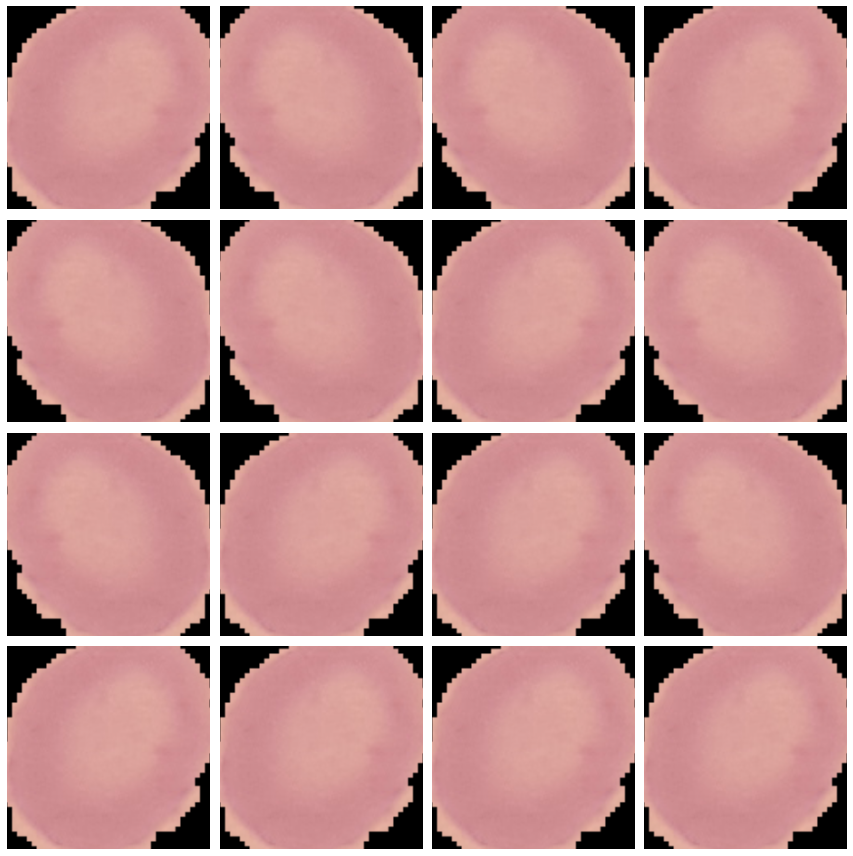

In [8]:
#Show an uninfected cell with transforms applied
ex_img = Image.open('cell_images/train/uninfected/C99P60ThinF_IMG_20150918_141314_cell_11.png')

t = train_transform
plt.figure(figsize=(12, 12))

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

In [9]:
train_data = ImageFolder(root=train_dir,transform=train_transform)
test_data = ImageFolder(root=test_dir,transform=test_transform)

In [10]:
train_loader = DataLoader(train_data,batch_size=64,shuffle=True)
test_loader = DataLoader(test_data,batch_size=64,shuffle=False)

In [11]:
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

n_classes = dict((i, v) for i, v in enumerate(train_data.classes))
print(len(n_classes))

categories = []
for d in os.listdir(train_dir):
    categories.append(d)

print(categories)

Training images available: 24958
Testing images available:  2600
2
['parasitized', 'uninfected']


In [12]:
trainiter = iter(train_loader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

In [13]:
model = models.wide_resnet50_2(pretrained=True)

In [14]:
print(model)
#Need to change (6): Linear(in_features=4096, out_features=1000, bias=True) in classifier

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [15]:
n_inputs = model.fc.in_features
last_layer = nn.Linear(n_inputs,2)
model.fc = last_layer

if train_on_gpu:
    model.cuda()

print(model.fc.out_features)

2


In [ ]:
model

In [17]:
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [19]:
model, history = train(
    model,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    save_file_name=save_file_name,
    max_epochs_stop=3,
    n_epochs=15,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.2404 	Validation Loss: 0.1971
		Training Accuracy: 92.08%	 Validation Accuracy: 93.88%

Epoch: 1 	Training Loss: 0.1870 	Validation Loss: 0.2011
		Training Accuracy: 93.88%	 Validation Accuracy: 92.92%

Epoch: 2 	Training Loss: 0.1714 	Validation Loss: 0.1722
		Training Accuracy: 94.25%	 Validation Accuracy: 94.00%

Epoch: 3 	Training Loss: 0.1588 	Validation Loss: 0.1664
		Training Accuracy: 94.61%	 Validation Accuracy: 94.77%

Epoch: 4 	Training Loss: 0.1496 	Validation Loss: 0.1639
		Training Accuracy: 94.84%	 Validation Accuracy: 94.92%

Epoch: 5 	Training Loss: 0.1483 	Validation Loss: 0.1322
		Training Accuracy: 94.90%	 Validation Accuracy: 95.15%

Epoch: 6 	Training Loss: 0.1410 	Validation Loss: 0.1577
		Training Accuracy: 95.16%	 Validation Accuracy: 94.62%

Epoch: 7 	Training Loss: 0.1354 	Validation Loss: 0.1324
		Training Accuracy: 95.30%	 Validation Accuracy: 95.31%

Epoch: 8 	Training Loss: 0.1344 	Validation Lo

Text(0.5, 1.0, 'Training and Validation Losses')

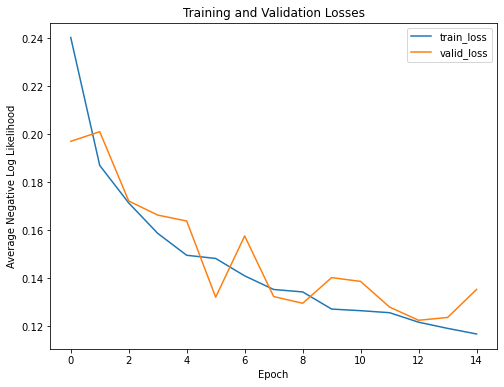

In [20]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

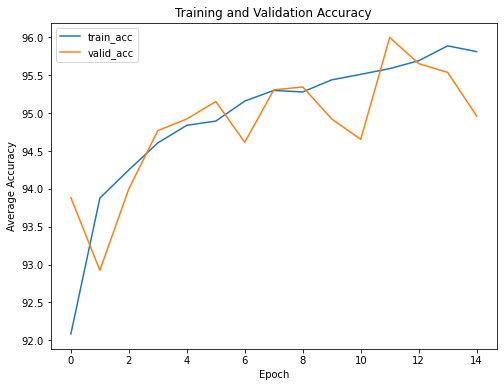

In [21]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

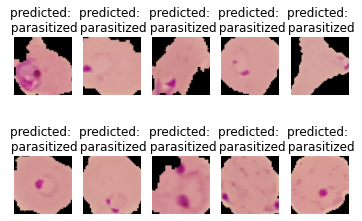

In [22]:
class_names = train_data.classes

show_predictions(model, class_names, n_images=10)

In [23]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [24]:
y_pred, y_test = get_predictions(model, test_loader)


In [25]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

 parasitized       0.98      0.92      0.95      1300
  uninfected       0.92      0.98      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



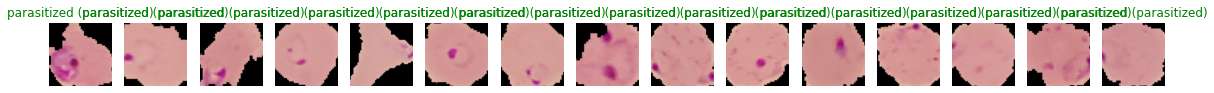

In [26]:
#Cuda out of memory error... 
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 4))
for idx in np.arange(15):
    ax = fig.add_subplot(2, 30/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

If we want to classify a new image (for example from google images) we can use the following functions to predict the probablility and get a Seaborn barplot to show the model's confidence 


In [30]:

def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = test_transform(img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

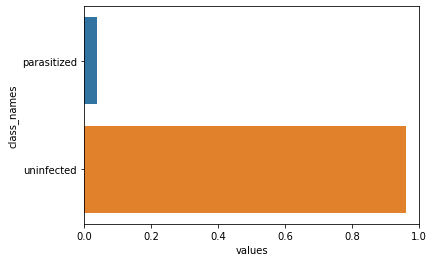

In [31]:
#Using an img from the train set as proof of concept that code works.
pred = predict_proba(model, 'cell_images/train/uninfected/C96P57ThinF_IMG_20150824_110812_cell_203.png')
show_prediction_confidence(pred, class_names)